In [8]:
import sys, importlib
importlib.reload(sys.modules['db_insert'])

<module 'db_insert' from 'C:\\Users\\mmazzolini\\OneDrive - Scientific Network South Tyrol\\Documents\\conda\\Runoff_prediction\\model_predict\\..\\db_insert.py'>

In [2]:
import sys
sys.path.insert(0, "..")

from climatology_ensemble import daily_climatology_p_et_ensemble

from create_daily_csv import readsnow_in_shp_db, xarray2df, check_data_gap, readnetcdf_in_shp_db, get_discharge_from_DB
from create_daily_csv import spatial_stats_daily_input
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plot
import xarray as xr
import datetime
import psycopg2
import matplotlib.pyplot as plt

from joblib import load
from base_f import create_it_matrix
from db_insert import insert, insert_pred

t_unit=10

In [3]:

#'ADO_DSC_ITC1_0072','ADO_DSC_ITH1_0012',
LIST=['ADO_DSC_CH03_0075',
     'ADO_DSC_AT31_0254',
     'ADO_DSC_ITC1_0072',
     'ADO_DSC_ITC1_0020',
     'ADO_DSC_CH07_0147',
     'ADO_DSC_AT31_0206',
     'ADO_DSC_ITH1_0012',
     'ADO_DSC_AT12_0280',
     'ADO_DSC_CH07_0100',
     'ADO_DSC_CH05_0201',
     'ADO_DSC_SI03_0148',
     'ADO_DSC_ITC1_0037',
     'ADO_DSC_FRK2_0042',
     'ADO_DSC_CH04_0011',
     'ADO_DSC_ITH2_0035',
     'ADO_DSC_SI03_0033',
     'ADO_DSC_FRK2_0041',
     'ADO_DSC_ITH5_0006',
     'ADO_DSC_CH07_0006']

In [4]:
era5_fileName_t=  'Z:\ADO\ZAMG\downscaled_archive\\2m_temperature-19790101_20201231-eusalp-era5_qm.nc'
era5_fileName_e = 'Z:\ADO\ZAMG\downscaled_archive\\potential_evapotranspiration-19790101_20201231-eusalp-qm_era5.nc'
era5_fileName_p = 'Z:\ADO\ZAMG\downscaled_archive\\total_precipitation-19790101_20201231-eusalp-qm_era5.nc'
era5_foldName_s = 'Z:\ADO\ZAMG\SNOWGRID\\'
# mask file needed to exclude pixels on the glaciers.
mask_file=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\SNOWGRID\\snowgrid_masks.nc'

path = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\Runoff_prediction\model_predict\climatology\\'

import sys, importlib
importlib.reload(sys.modules['create_daily_csv'])

C:\Users\MMAZZO~1\AppData\Local\Temp/ipykernel_11752/860301747.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,8))


UniqueViolation: duplicate key value violates unique constraint "pred_disch_id_station_key"
DETAIL:  Key (id_station)=(ADO_DSC_CH07_0006) already exists.


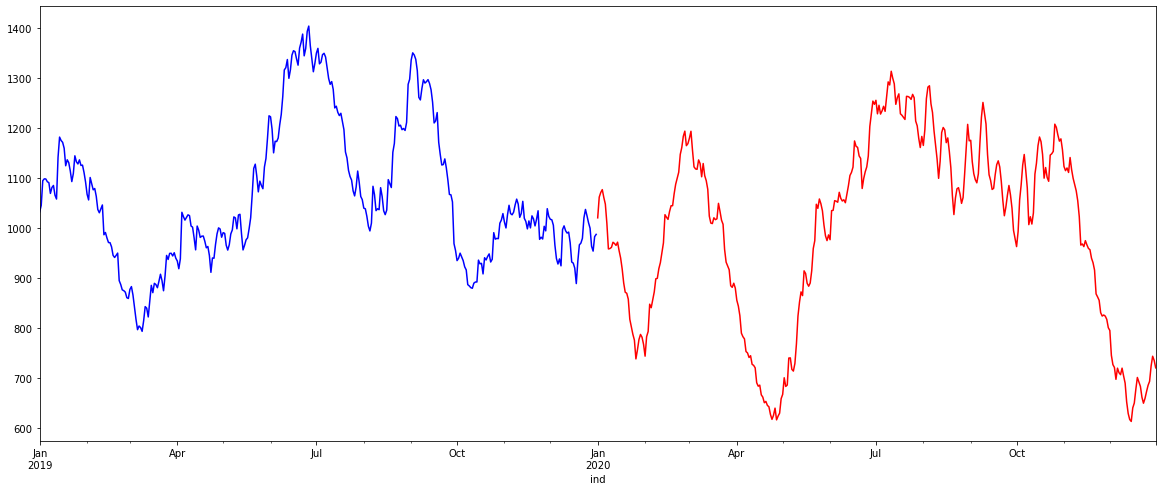

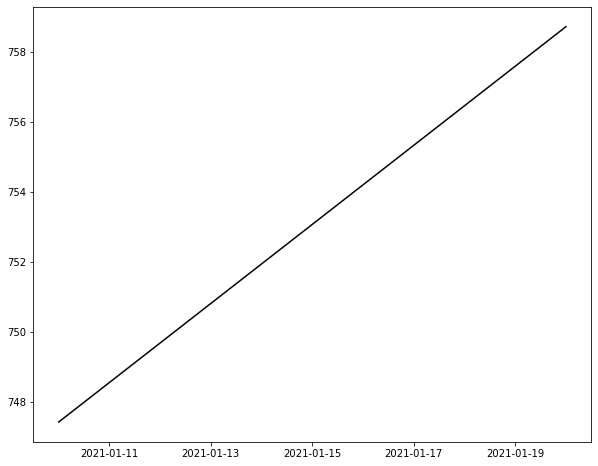

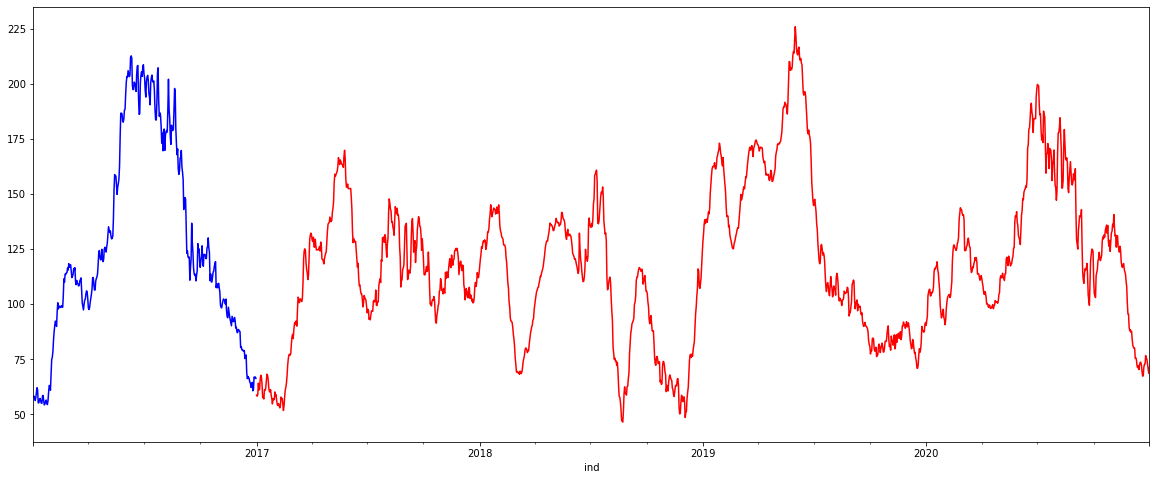

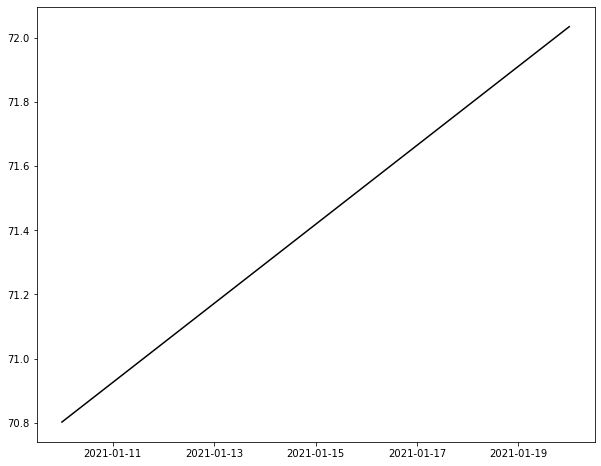

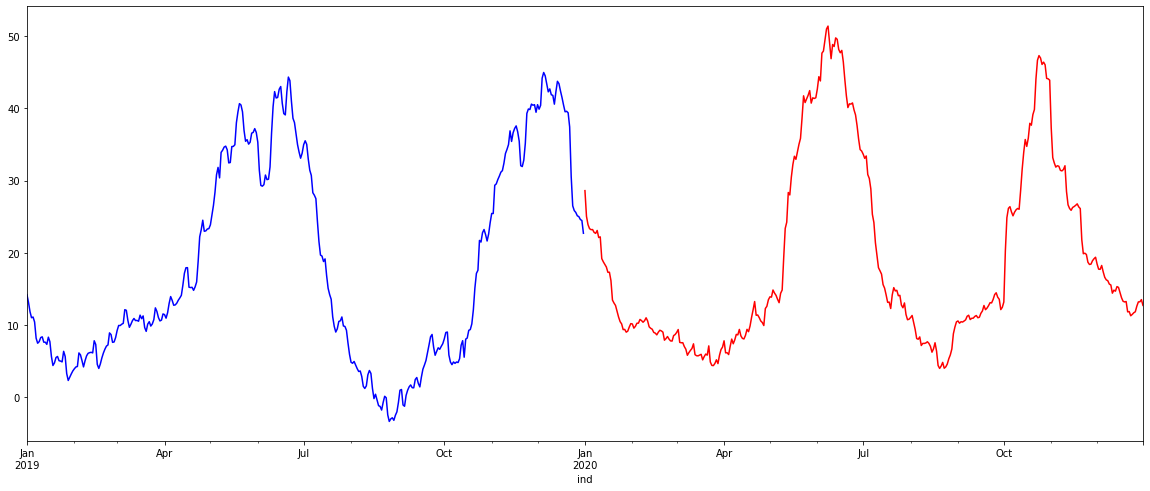

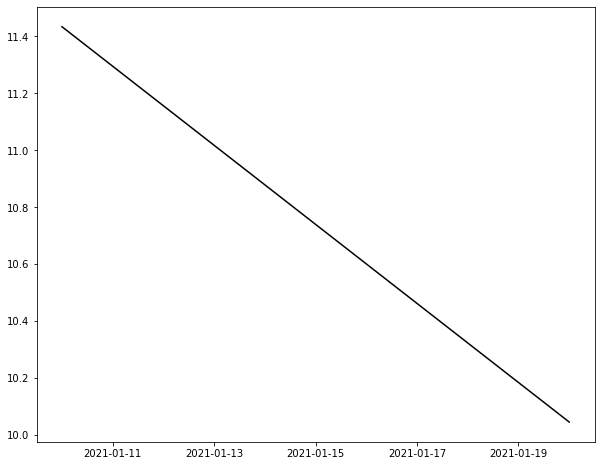

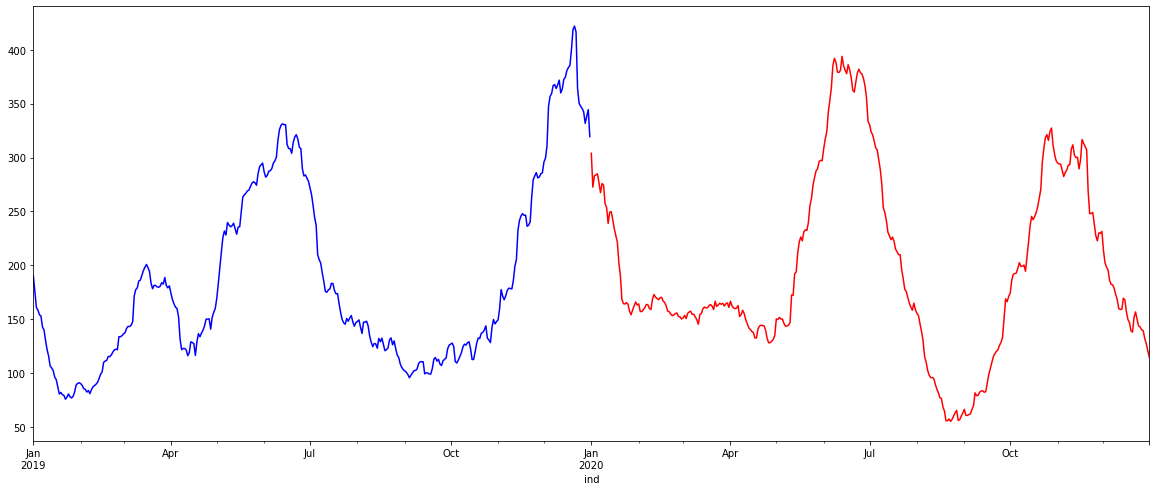

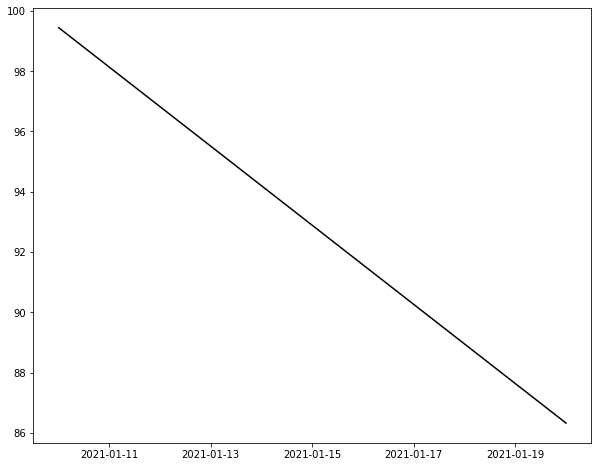

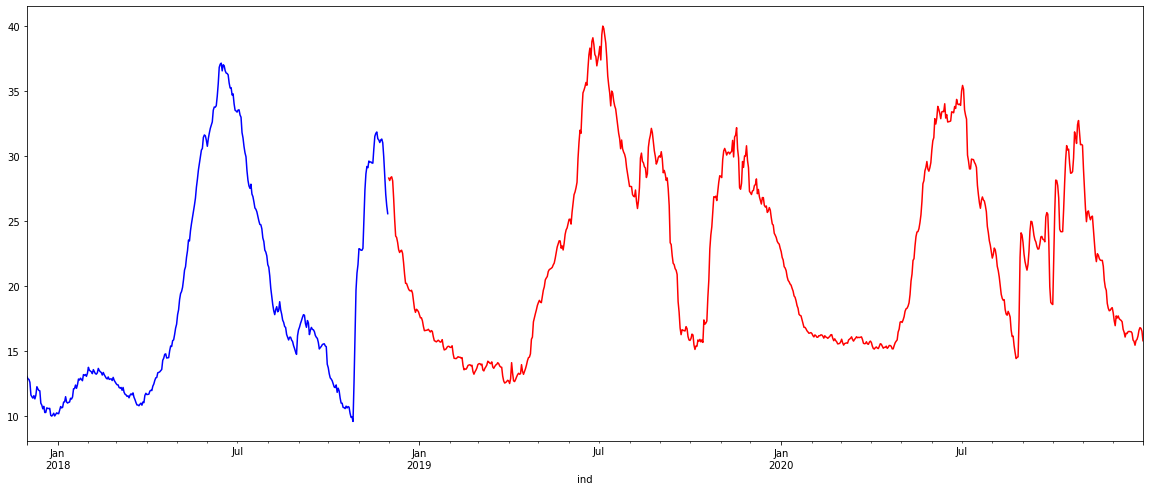

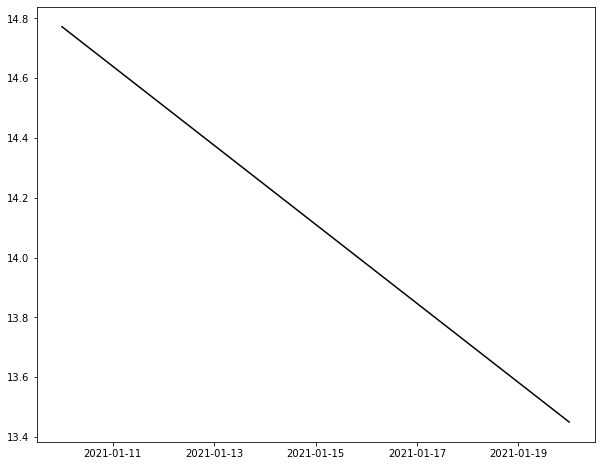

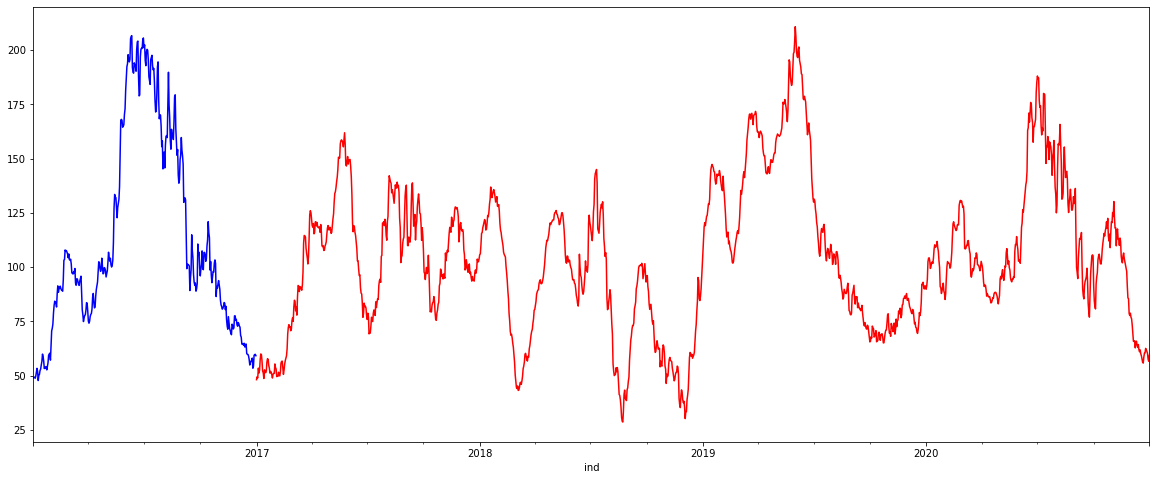

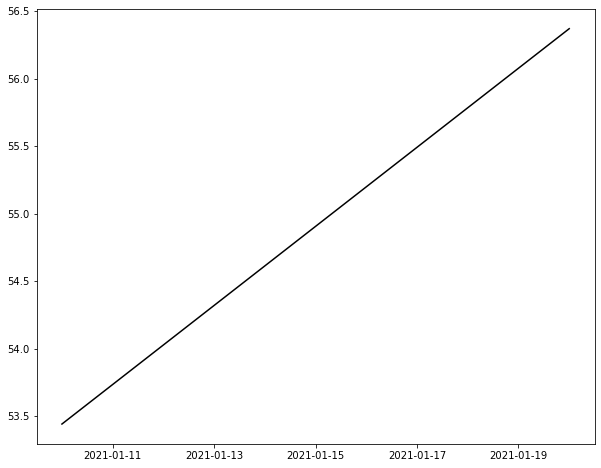

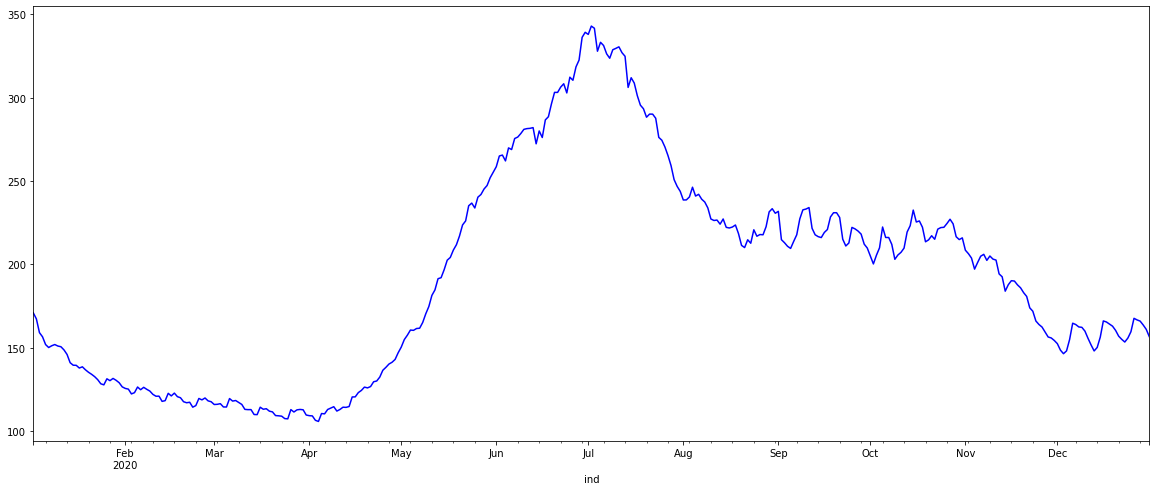

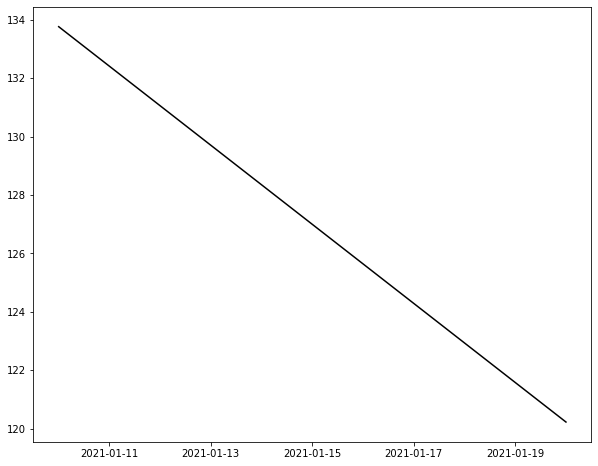

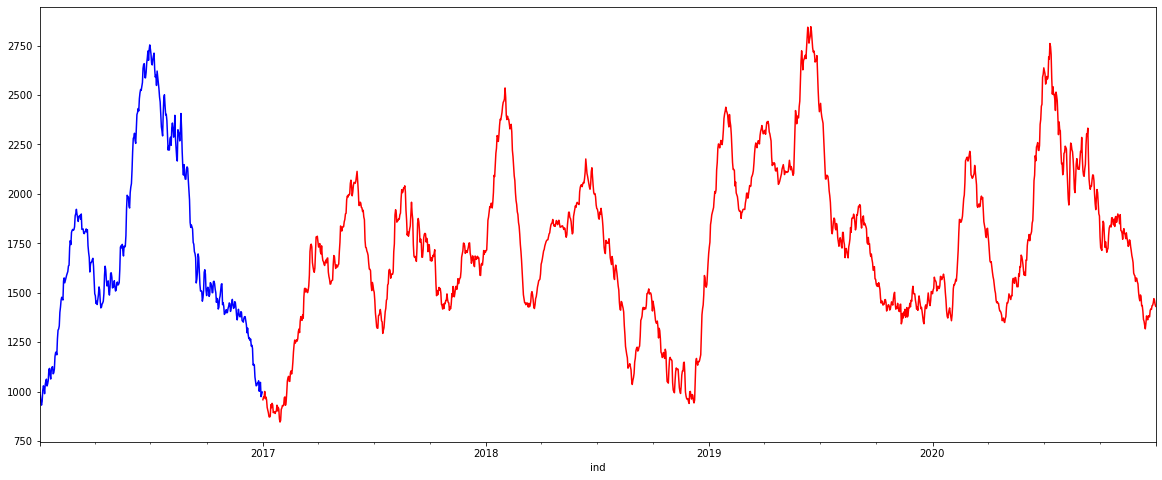

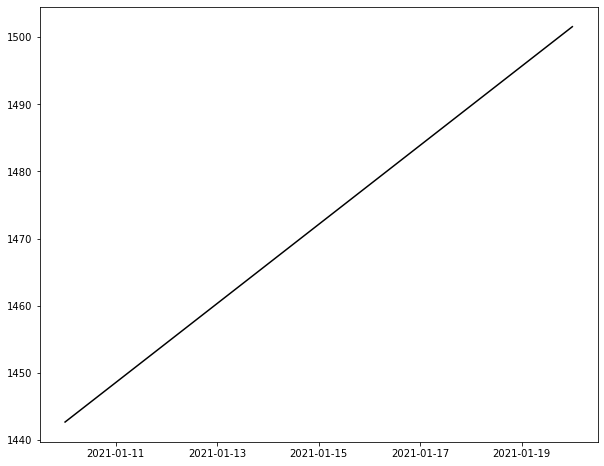

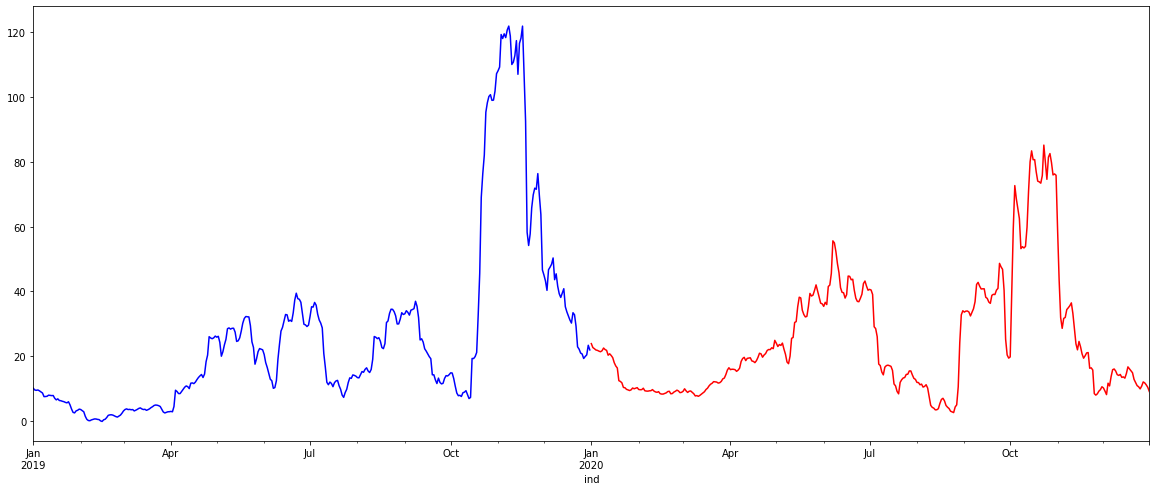

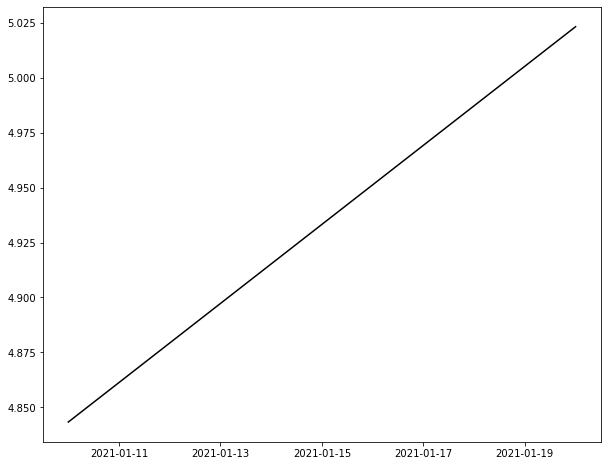

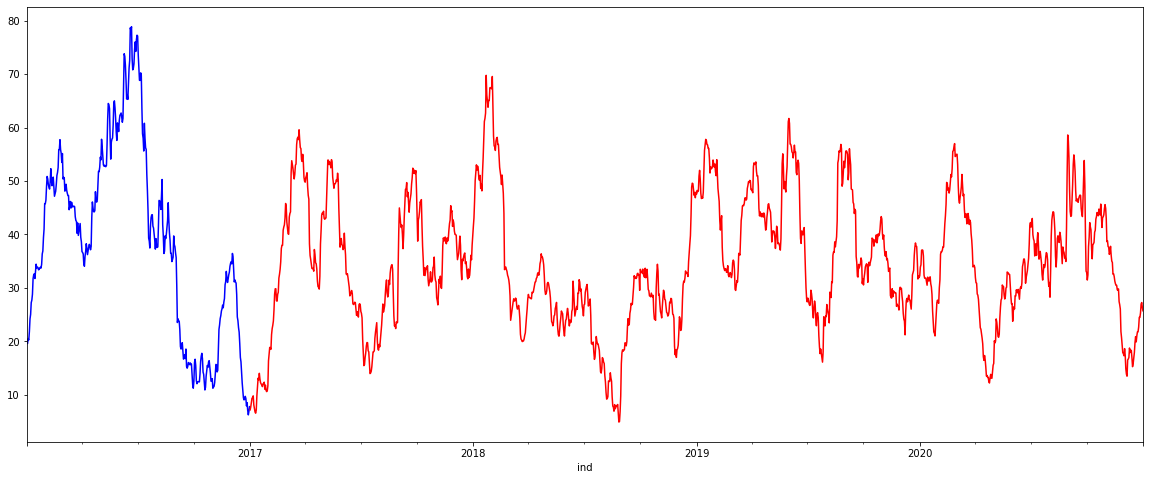

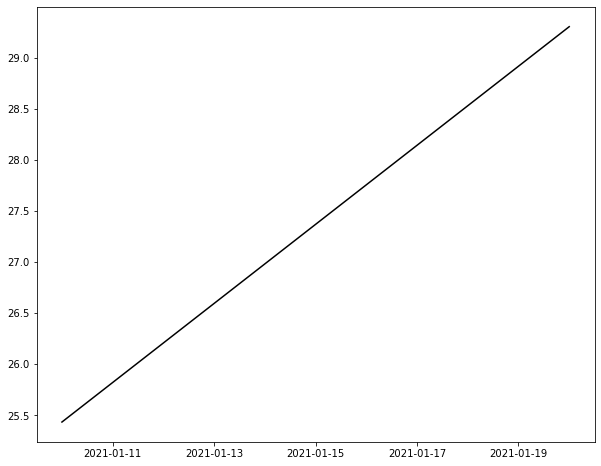

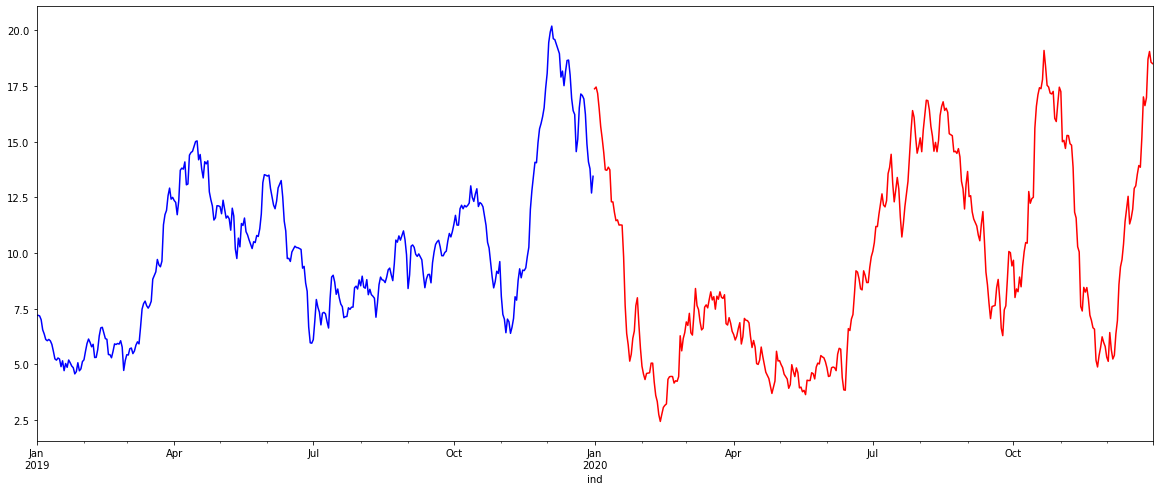

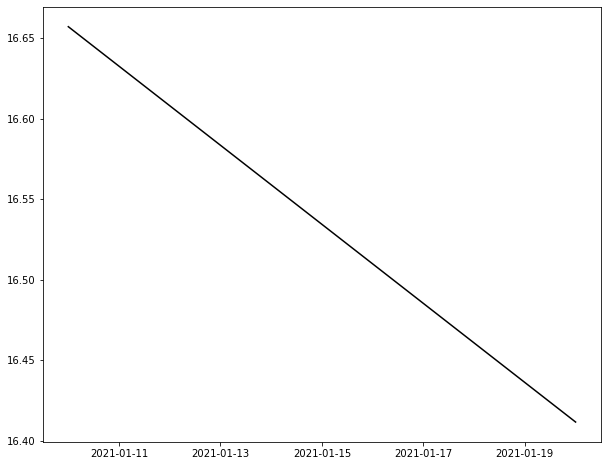

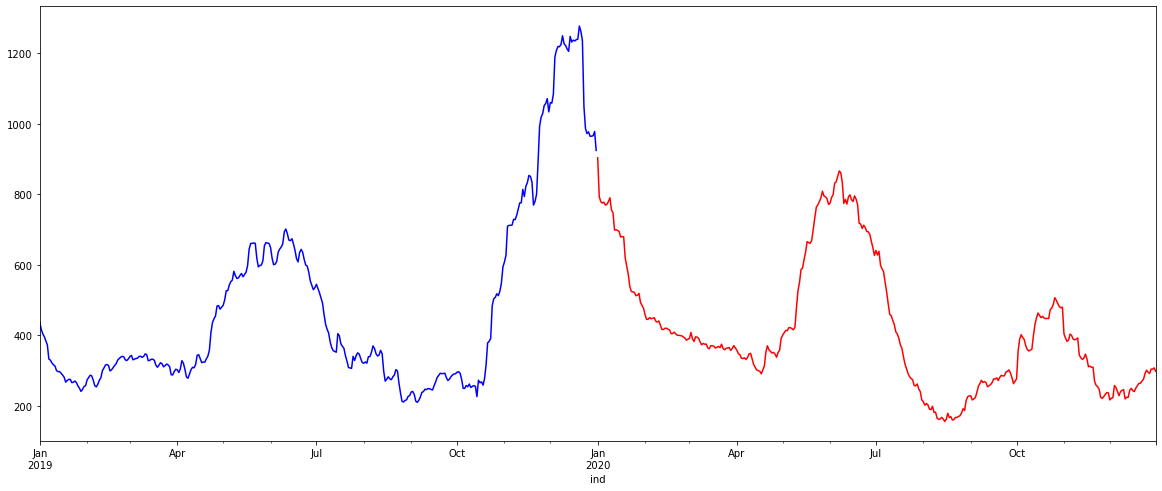

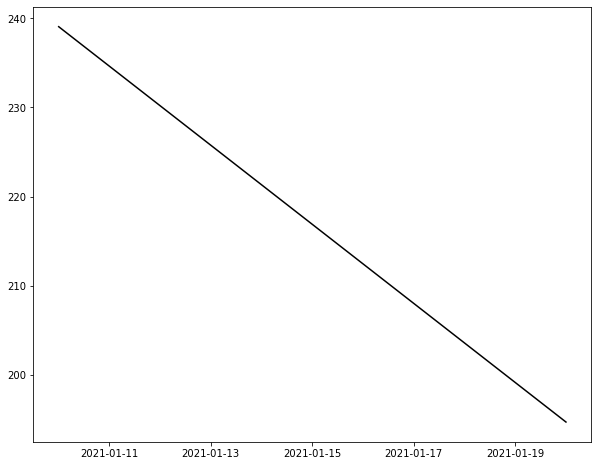

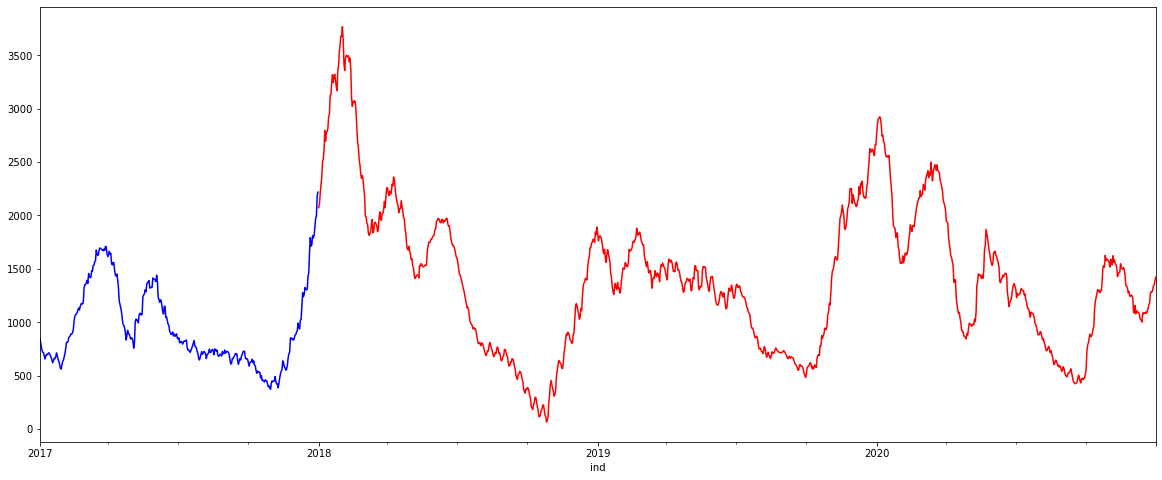

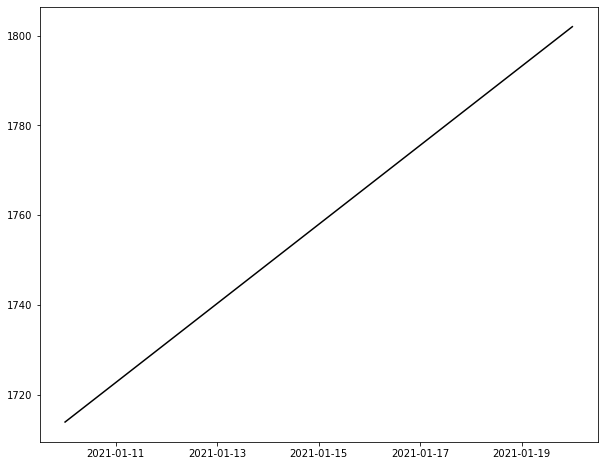

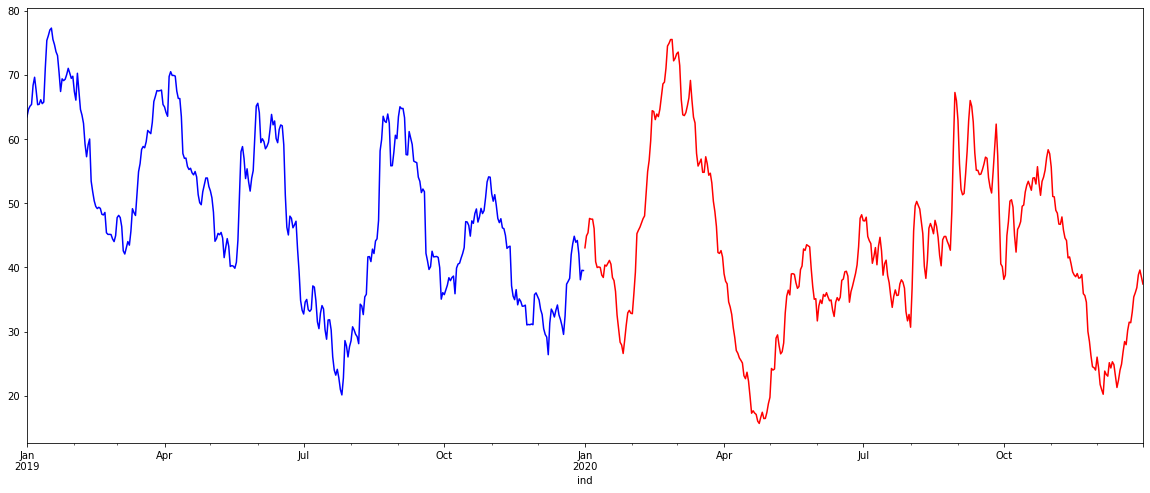

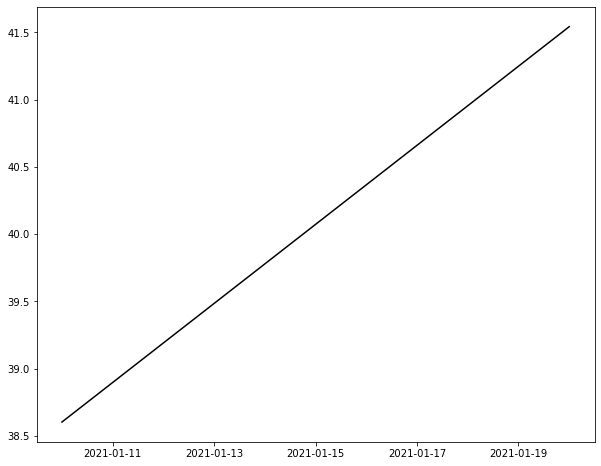

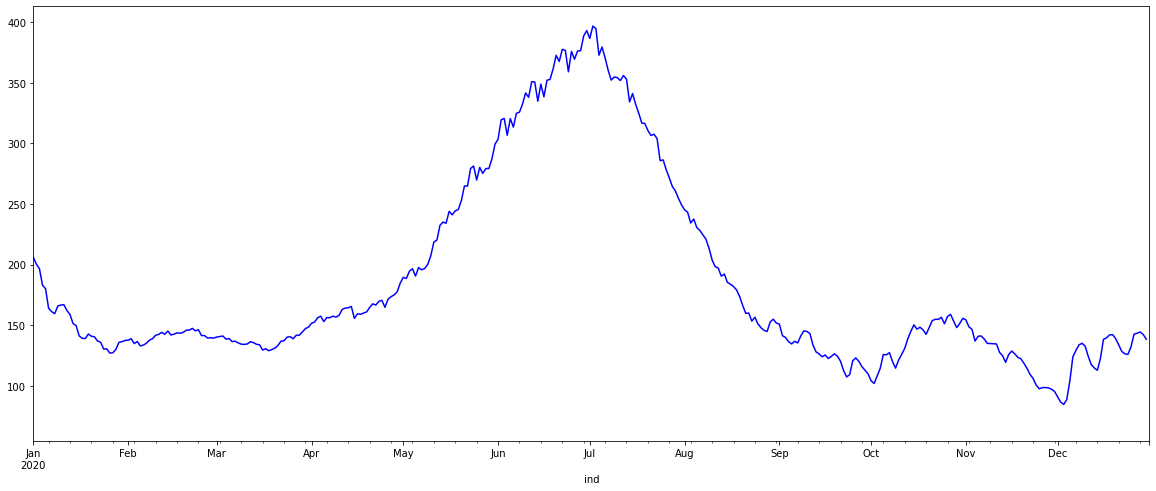

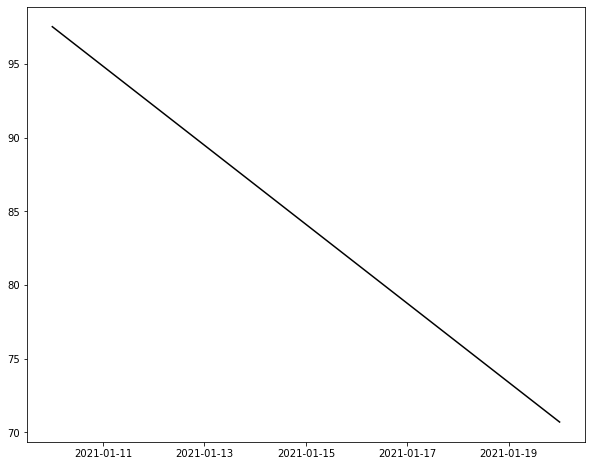

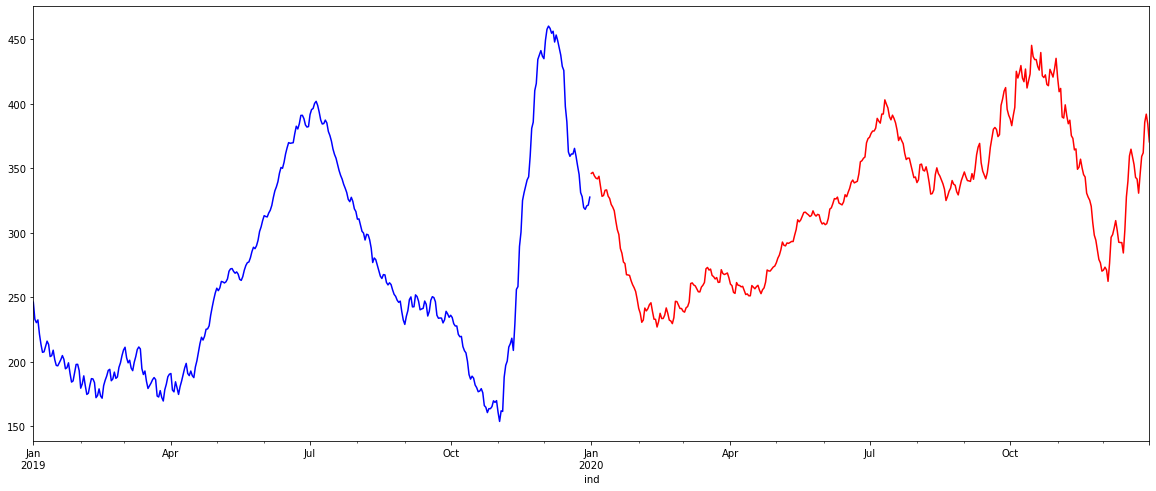

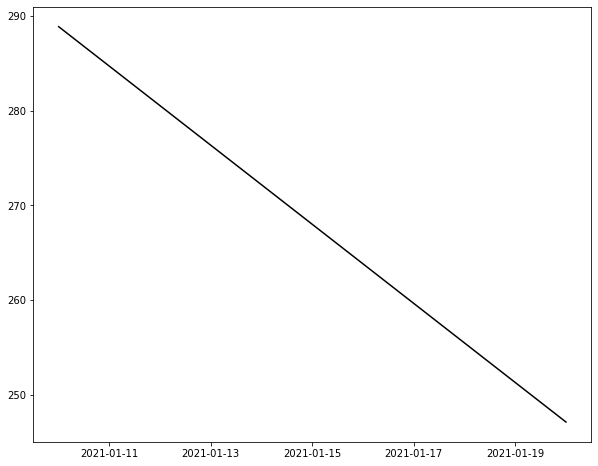

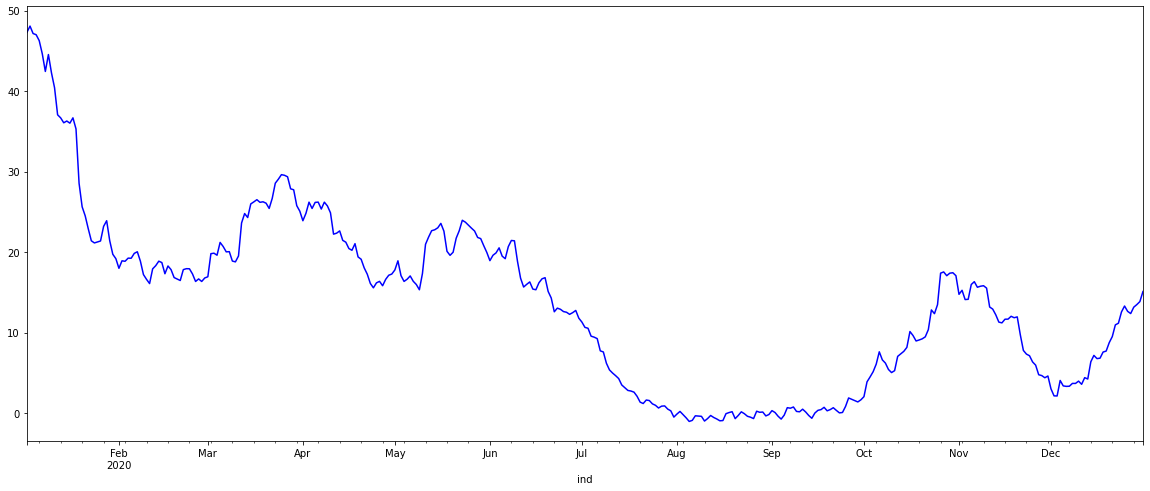

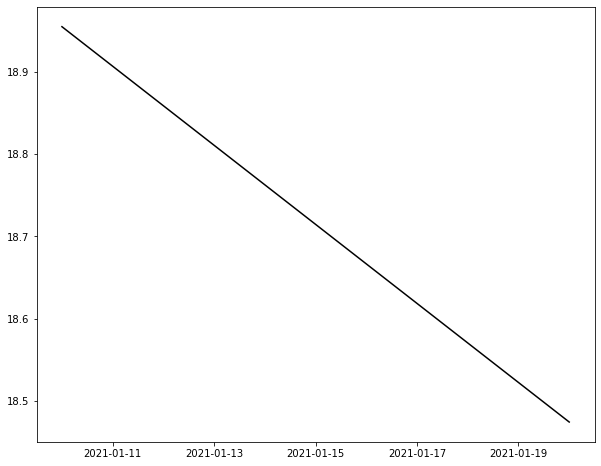

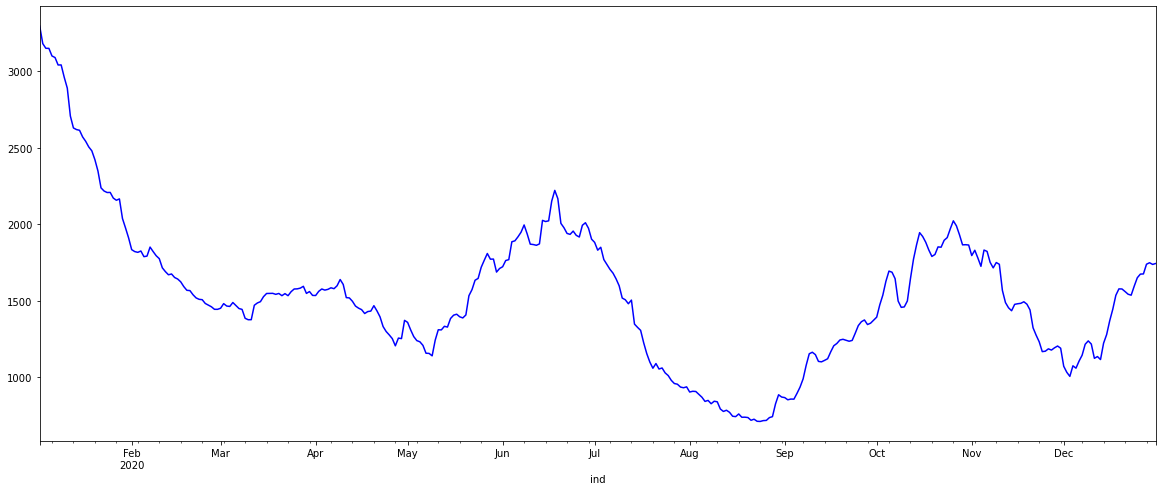

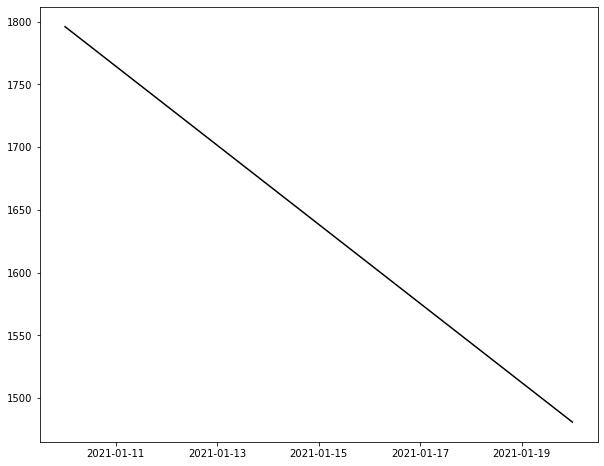

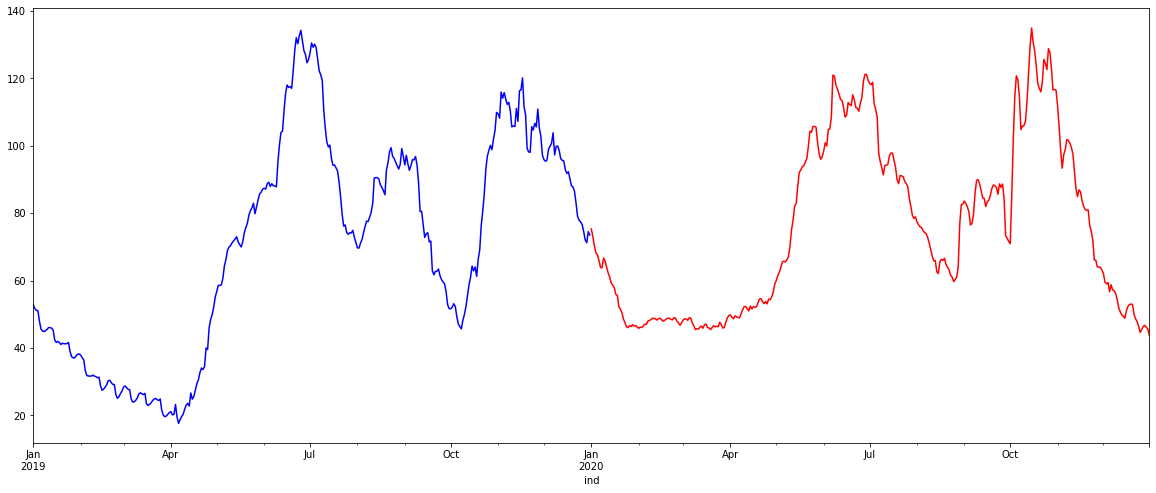

In [5]:
for STAT_CODE in LIST:

    conn = psycopg2.connect(host="10.8.244.31",
                       database="climate_data",
                       user="ado_admin",
                       password="oda347hydro",
                       port=5432)
                       
    cur = conn.cursor()
    
    # get the metadata
    query = f"""
            SELECT "id_station", MAX("date") FROM "ML_discharge"."mod_disc" 
            WHERE "meas_disch_presence" = TRUE
            GROUP BY "id_station"    
            """
    df = pd.read_sql_query(query,conn)
    df.index=df.id_station
    last_mes_date=np.datetime64(df.loc[STAT_CODE][1])

    # get the metadata
    query = f"""
            SELECT "id_station", MAX("date") FROM "ML_discharge"."mod_disc"
            GROUP BY "id_station"    
            """
    df2 = pd.read_sql_query(query,conn)

    # close the connection when finished
    cur.close()
    conn.close()

    df2.index=df2.id_station
    last_mod_date=np.datetime64(df2.loc[STAT_CODE][1])
    
    ###### create the in_matrix  by selecting 
    t2m = readnetcdf_in_shp_db(era5_fileName_t,STAT_CODE ,plot=False,res=5500)['t2m']
    #select dates
    last_mod_date=np.datetime64(df.loc[STAT_CODE][1])
    last_data_date=np.datetime64(np.array(t2m.time[-1]),'D')
    
    if  (last_mod_date <= last_data_date):


        t2m = t2m.sel(time=slice(last_mod_date - np.timedelta64(365,'D'),last_data_date))
        t2m = xarray2df(t2m.resample(time='1d').sum(skipna=False), 'T','t2m')
        ### ERA5 total precipitation

        #CLIP TO THE SHAPEFILE
        tp = readnetcdf_in_shp_db(era5_fileName_p,STAT_CODE ,plot=False,res=5500)['tp']
        tp = tp.sel(time=slice(last_mod_date - np.timedelta64(365,'D'),last_data_date))
        tp = xarray2df(tp.resample(time='1d').sum(skipna=False), 'P','tp')


        ### ERA5 evapotranspiration

        #CLIP TO THE SHAPEFILE
        pet = readnetcdf_in_shp_db(era5_fileName_e,STAT_CODE ,plot=False,res=5500)['pet']
        pet = pet.sel(time=slice(last_mod_date - np.timedelta64(365,'D'),last_data_date))
        pet = xarray2df(pet.resample(time='1d').sum(skipna=False), 'E','pet')


        ### ERA5 SNOW VARIABLES

        #CLIP TO THE SHAPEFILE
        s = readsnow_in_shp_db(era5_foldName_s,mask_file,STAT_CODE ,plot=False,res=5500)['swe_tot']
        s = s.sel(time=slice(last_mod_date - np.timedelta64(365,'D'),last_data_date))
        s = xarray2df(s.resample(time='1d').sum(skipna=False), 'S','swe_tot')

        #CONCATENATE THE VARIABLES
        daily_input = pd.concat([t2m, s, tp, pet], axis=1, join='inner')
        daily_input_stat = spatial_stats_daily_input(daily_input)
      

        ########load the model
        
        fld = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\Runoff_prediction\model_train\models\\'
        model = load(fld+STAT_CODE+'.joblib')
        
        
        ########## get the previously modelled discharge and plot it

        conn = psycopg2.connect(host="10.8.244.31",
                           database="climate_data",
                           user="ado_admin",
                           password="oda347hydro",
                           port=5432)

        cur = conn.cursor()

        query = f"""
                SELECT "discharge", "date","meas_disch_presence" FROM "ML_discharge"."mod_disc" 
                WHERE "id_station" = '{STAT_CODE}'
                AND "date" > '{(last_mes_date-np.timedelta64(365,'D'))}'
                """
        old = pd.read_sql_query(query,conn)

        # close the connection when finished
        cur.close()
        conn.close()

        for i in range(old.shape[0]):
            old.loc[i,'ind'] = np.datetime64(old.iloc[i].date)

        old.index=old.ind
        old.drop(columns=['ind','date'], inplace=True)
        



        plt.figure(figsize=(20,8))
        old_blue=old[old.meas_disch_presence==True]

        old_blue.discharge.plot.line(color='blue')

        old_red=old[old.meas_disch_presence==False]
        
        if not old_red.empty:
            old_red.discharge.plot.line(color='red')

        ##################################################################


        #### finally: substitute the latest values with the climatology

        #read the climatology on the saved csv
        daily_clim = pd.read_csv(path + STAT_CODE + '.csv')

        #add data to the daily_input_stat dataframe
        n=daily_input_stat.shape[1]

        #add 20 rows to the daily_input_stat dataframe
        for i in range(1,21):
            daily_input_stat.loc[last_data_date+np.timedelta64(i,'D')]=np.repeat(0,n)

        #create the input matrix
        daily_input_stat['Q'] = 0
        in_matrix = create_it_matrix(daily_input_stat, int(12*30/t_unit) ,t_unit)
        in_matrix.drop(columns='Q',inplace=True)
        
        #select the the input data interesting
        in_matrix = in_matrix[str((last_mod_date).astype('datetime64[D]')):] #str(last_data_date.astype('datetime64[D]'))

        
        #create a in_matrix for predictions, with the +10days and +20days
        in_matrix_pred=pd.DataFrame(data=None)
        pred_date=last_data_date + np.timedelta64(t_unit,'D')
        pred_date_2=last_data_date + np.timedelta64(2*t_unit,'D')
        
        #fill it with the same in_matrix values
        in_matrix_pred[pred_date] = in_matrix.loc[pred_date]
        in_matrix_pred[pred_date_2] = in_matrix.loc[pred_date_2]
        in_matrix_pred=in_matrix_pred.transpose()

        #substitute the data for the columns representing the last 10 days (names ending with _0) 
        #and the last 20 to 10th days (names ending with _-1)
        lt=1
        
        #select the destination and source columns
        change_dest = [c for c in in_matrix_pred.columns if c.split('_')[1] == str(-lt + 1)]
        change_source = [c.split('_')[0] for c in change_dest]
        
        #update for the first prediction date (+10)
        pred_dayofyear=in_matrix_pred.index[0].dayofyear
        in_matrix_pred.loc[in_matrix_pred.index[0], change_dest]=daily_clim.loc[pred_dayofyear][change_source].values

        #update for the first prediction date (+20)
        pred_dayofyear=in_matrix_pred.index[1].dayofyear
        in_matrix_pred.loc[in_matrix_pred.index[1], change_dest]=daily_clim.loc[pred_dayofyear][change_source].values

        
        #and the last -20 to -10 days (names ending with _-1) 
        lt=lt+1
        
        #select the destination and source columns
        change_dest = [c for c in in_matrix_pred.columns if c.split('_')[1] == str(-lt + 1)]
        change_source = [c.split('_')[0] for c in change_dest]

        #(this time only for the 20days prediction.)
        pred_dayofyear=in_matrix_pred.index[0].dayofyear
        in_matrix_pred.loc[in_matrix_pred.index[1], change_dest]=daily_clim.loc[pred_dayofyear][change_source].values


        # now give the in_matrix_pred to the model
        data=(model.predict(in_matrix_pred))
        results=pd.DataFrame(data=data.reshape(1,-1), index=[last_data_date], columns=['10','20'])
        
        #insert the prediction in the database.
        insert_pred(STAT_CODE,results)
        
        
        
        x=((results.index+np.timedelta64(10,'D')).date,(results.index+np.timedelta64(20,'D')).date)
        y=(results.values.transpose())
                    
        plt.plot(x,y, color='black')
        
        plt.figure(figsize=(10,8))
        plt.plot(x,y, color='black')


In [13]:
[c + '_Q25' for c in change_source]

['T_Q25',
 'T5_Q25',
 'T25_Q25',
 'T75_Q25',
 'T95_Q25',
 'S_Q25',
 'S5_Q25',
 'S25_Q25',
 'S75_Q25',
 'S95_Q25',
 'P_Q25',
 'P5_Q25',
 'P25_Q25',
 'P75_Q25',
 'P95_Q25',
 'E_Q25',
 'E5_Q25',
 'E25_Q25',
 'E75_Q25',
 'E95_Q25']

In [12]:
daily_clim.columns

Index(['day_of_year', 'P', 'P5', 'P25', 'P75', 'P95', 'T', 'T5', 'T25', 'T75',
       'T95', 'S', 'S5', 'S25', 'S75', 'S95', 'E', 'E5', 'E25', 'E75', 'E95',
       'P_Q75', 'P5_Q75', 'P25_Q75', 'P75_Q75', 'P95_Q75', 'T_Q75', 'T5_Q75',
       'T25_Q75', 'T75_Q75', 'T95_Q75', 'S_Q75', 'S5_Q75', 'S25_Q75',
       'S75_Q75', 'S95_Q75', 'E_Q75', 'E5_Q75', 'E25_Q75', 'E75_Q75',
       'E95_Q75', 'P_Q25', 'P5_Q25', 'P25_Q25', 'P75_Q25', 'P95_Q25', 'T_Q25',
       'T5_Q25', 'T25_Q25', 'T75_Q25', 'T95_Q25', 'S_Q25', 'S5_Q25', 'S25_Q25',
       'S75_Q25', 'S95_Q25', 'E_Q25', 'E5_Q25', 'E25_Q25', 'E75_Q25',
       'E95_Q25'],
      dtype='object')